In [1]:
# fitting function in Python:
'''optimize.curve_fit and lestq
leastsq can fit residuals:
    def residuals(coeffs, y, t):...
    leastsq(residuals, x0, args=(y, t)), take care of the order
    
curve_fit(func, xdata, ydata, x0, sigma) can fit function
    When defining func, put x as the first input.
'''

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, FloatSlider, RadioButtons
from scipy import optimize
import scipy as sc
import os.path
%matplotlib ipympl

In [3]:
np.sin(10/180*3.14)

0.17356104045380671

## Single spin mag

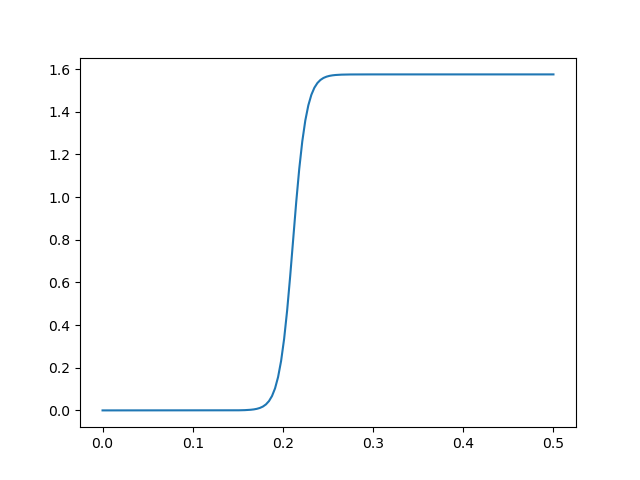

In [2]:
ut2k=0.6717  # convert mub*Tesla to K
#jz=-0.2; jx=0.1; jy=0.1;jxz=0.1 #exchange interaction in K
#moment=2.6 # in muonB

def mag(g,jz,tempe,field):
    p1=np.exp(-(g/2*field/ut2k)/tempe) #probability for the spin unparallel to the field
    p2=np.exp(-(-g/2*field/ut2k-jz*6)/tempe)#probability for the spin unparallel to the field
    prob1=p1/(p1+p2);prob2=p2/(p1+p2)
    mag=(1-prob1+prob2)*g/2
    return mag
field=np.linspace(0,0.5,150)

plt.figure()
plt.plot(field,mag(6.3,-0.33,0.07,field)/4)
plt.show()

## Powder with Ising spins

[0.11084096 0.65706397 1.02973027 1.24500696 1.36463278 1.43284043
 1.47370974 1.49956243 1.51676424 1.52872556]
(10,) (10,)


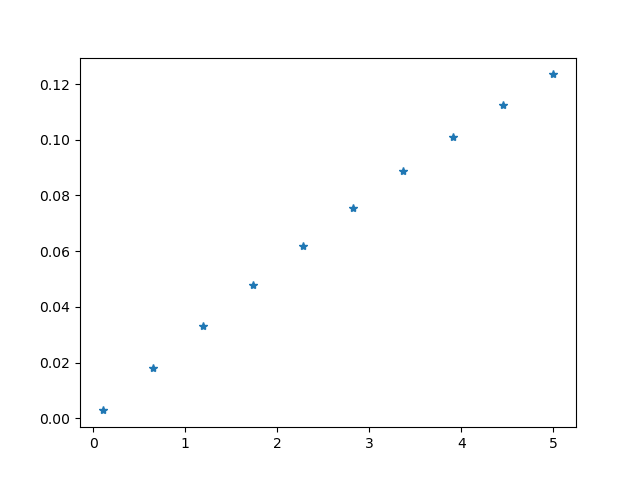

In [2]:
#　ＭＨ（Ｔ）　ｆｏｒ　ｅｆｆｅｃｔｉｖｅ　ｓｐｉｎ　ｈａｌｆ　ｐｏｗｄｅｒ　ｓａｍｐｌｅ，　ｅｇ，Ｎｄ２Ｚｒ２Ｏ７
import scipy.integrate as integrate

kb = 1.38*10**-23
mb = 9.27*10**-24 # in units of Kelvin
jp = 1/2.       # for our Ising Moment
def isingpow(h, t, g): # h cannot be a array due to func 'integrate' can not take array as a upper limit
    p1 = mb*jp/(kb*t)
    fun =lambda v: v*np.tanh(g*p1*v)  #x= g p1 v where v is the field and the varble to integrate
    smh = g*jp*integrate.quad(fun, 0.00001, h)[0]/h**2
    return smh
# we can vectorize the function only for 'h'
# https://stackoverflow.com/questions/41223186/numpy-vectorization-with-integration
visingpow = np.vectorize(isingpow, excluded=['t','g']) # vectorize the func for 'h'

# Multi-curve fitting: def a global error
def err(t, g, x, y):
    x, y = x[~np.isnan(x)], y[~np.isnan(y)] 
    #err = visingpow(x, t, g) - y # use vectorized scipy function
    err = np.array([isingpow(x[i], t, g) - y[i] for i in np.arange(0, x.shape[0])]).ravel() 
    return  err 
# have to put "ravel()" or 'flatten()' otherwise error on 'hstack' when using leastsq (no problem for non-fit use)


x=np.linspace(0.1,5, 10)
print(visingpow(x, 2, 6.3))

# plot test
y=[]
for xi in x: 
    y.append(isingpow(xi,2,1))
#y = isingpow(x,2,6.3)
print(x.shape, np.array(y).shape)

plt.figure()
plt.plot(x,np.array(y),'*')
plt.show()

### MH fitting for Ho2GaSbO7

MH_2K.dat
MH_5K.dat
MH_10K.dat
MH_15K.dat
MH_20K.dat
MH_30K.dat


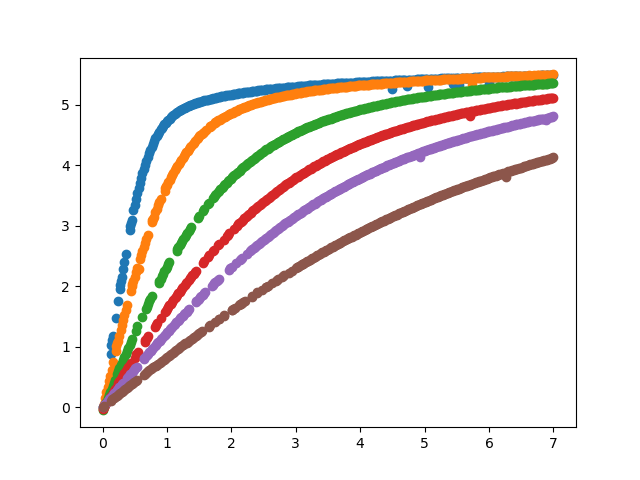

In [3]:
fpath = r'D:\4_Physical_Properties\Ho2GaSbO7\MT_MH'
Ts = [2,5,10,15,20,30]#,40]#,50,100,150]
dat = []
for t in Ts:
    fname = 'MH_{:d}K.dat'.format(t)
    print(fname)
    temp = np.genfromtxt(os.path.join(fpath, fname), usecols=[1,2])
    mask = temp[:,0]>0
    dat.append(temp[mask,:])

for i,temp in enumerate(dat):
    temp[:,0] = temp[:,0]/10000 # Oe->T
    temp[:,1] = temp[:,1]/0.011*633.34/2/5585 # ub/mol
    dat[i] = temp
    
plt.figure()
for temp in dat:
    plt.plot(temp[:,0],temp[:,1],'o')
    
plt.show()

[21.50957121] 1


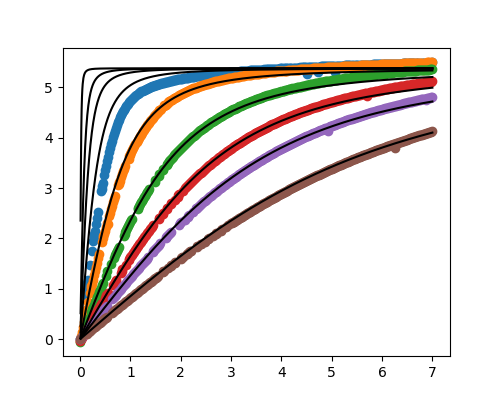

In [4]:
# fit
def err_global(g):
    err0=[]
    for i in range(len(Ts)):
        errc=err(Ts[i], g, dat[i][:,0],dat[i][:,1])
        err1=np.concatenate((err0,errc))
        err0=err1
    return err0 #(err0**2).sum()

p_best,success=optimize.leastsq(err_global, 20)
print(p_best, success)

# plot dat and fit
fig = plt.figure(figsize=(5,4))
for temp in dat:
    plt.plot(temp[:,0],temp[:,1],'o')
    
xdat=np.linspace(0.01,7, 1000)
for t in np.hstack(([0.1, 0.5, 1],Ts)).ravel():
    ydat = np.array([isingpow(xdat[i], t, p_best[0]) for i in np.arange(0, xdat.shape[0])])
    plt.plot(xdat,ydat,'black')
    
plt.show()

### MH fitting for Nd2Zr2O7

<IPython.core.display.Javascript object>


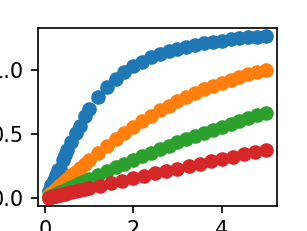

In [4]:
# MH data for Nd2Zr2O7
fpath = r'D:\3_Physical Properties\Gd2Zr2O7\2_NZO_pow_MH_2-5-10-20k_OldSQUID_Sep2015.txt'
mhdat = np.genfromtxt(fpath, usecols=(0,1,2,3,4,5,6,7), skip_header=1) # MH at 1.8, 5, 10, 20K

Ts = [1.8, 5., 10., 20] # temperatures

for i in xrange(0, mhdat.shape[1],2):
    mhdat[:,i] = mhdat[:,i] / 10000. # change the unit to Tesla

#plot data
for i in xrange(0, mhdat.shape[1],2):
    plt.plot(mhdat[:,i],mhdat[:,i+1],'o')


[ 5.17810666] 1


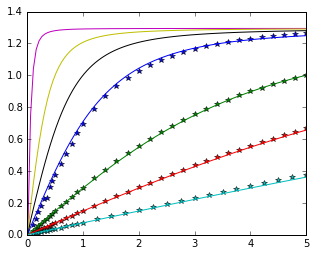

'\nWhy the fitting result is similar but different with that in Mathematica (5.24) ?\nThe function to fit does not produece the same curve if fix the same parameters!!!\nProbelem with Integrate, data without simga?\n'

In [71]:
# multi-curve fitting: def a global error
def err_global(g):
    err0=[]
    for i in range(len(Ts)):
        errc=err(Ts[i], g, mhdat[:,i*2],mhdat[:,i*2+1])
        err1=np.concatenate((err0,errc))
        err0=err1
    return err0 #(err0**2).sum()


# fit
p_best,success=optimize.leastsq(err_global, 5.5)
print p_best, success
#print err_global(p_best)


# plot dat and fit
fig = plt.figure(figsize=(5,4))
for i in xrange(0, mhdat.shape[1],2):
    plt.plot(mhdat[:,i],mhdat[:,i+1],'*')
    
xdat=np.linspace(0.01,5, 100)
for t in np.hstack(([0.1, 0.5, 1],Ts)).ravel():
    ydat = np.array([isingpow(xdat[i], t, p_best[0]) for i in np.arange(0, xdat.shape[0])])
    plt.plot(xdat,ydat)
    
plt.show()  

'''
Why the fitting result is similar but different with that in Mathematica (5.24) ?
The function to fit does not produece the same curve if fix the same parameters!!!
Probelem with Integrate, data without simga?
'''

In [ ]:
str = 'Hello World!'

print str          # Prints complete string
print str[0]       # Prints first character of the string
print str[-5:-1]     # Prints characters starting from 3rd to 5th

### Fit MH of Nd2Sn2O7

In [81]:
fpath = r'D:\3_Physical Properties\Nd2Sn2O7'
fnames = ['Nd2Sn2O7_powder_1stBatch_mt_0p1T.txt','Nd2Sn2O7_powder_1stBatch_mt_1T.txt',
         'Nd2Sn2O7_powder_1stBatch_mh_1p8_5_10_20K.txt', 'Nd2Sn2O7_powder_1stBatch_mh_squid.txt']

#mh = np.genfromtxt(os.path.join(fpath,fnames[2]), usecols=(0,1,2), skip_header=0)
mh = np.genfromtxt(os.path.join(fpath,fnames[3]), usecols=(0,1,2), skip_header=0)
print mh
# convert units
mh[:,1], mh[:,2] = mh[:,1]/10000, mh[:,2]/0.02432*637.8998/5585/2
#mh_squid[:,1], mh_squid[:,2] = mh_squid[:,1]/10000, mh_squid[:,2]/0.02432*637.8998/5585/2
print mh

[[  1.79979670e+00   1.16069540e-01  -1.12098400e-03]
 [  1.79916710e+00   4.99563263e+02   1.60209580e-02]
 [  1.79958713e+00   9.99730103e+02   3.31077720e-02]
 ..., 
 [  2.00004530e+01   3.99970972e+03   1.33833950e-02]
 [  2.00005608e+01   1.99961108e+03   6.68313900e-03]
 [  2.00005121e+01  -1.85711250e-01  -9.98000000e-05]]
[[  1.79979670e+00   1.16069540e-05  -2.63229850e-03]
 [  1.79916710e+00   4.99563263e-02   3.76204689e-02]
 [  1.79958713e+00   9.99730103e-02   7.77437845e-02]
 ..., 
 [  2.00004530e+01   3.99970972e-01   3.14269343e-02]
 [  2.00005608e+01   1.99961108e-01   1.56933701e-02]
 [  2.00005121e+01  -1.85711250e-05  -2.34350705e-04]]


In [82]:
# we can vectorize the function for 't' and 'h'
visingpow = np.vectorize(isingpow, excluded=['g'])
def multi_visingpow(t_h, g): 
    # h and t can be arrays and combined for using curve_fit (only accept one varible input)
    # https://stackoverflow.com/questions/28372597/python-curve-fit-with-multiple-independent-variables
    t, h = t_h[:,0], t_h[:,1]
    return visingpow(h, t, g)

# Fit g factor
popt, pcov = optimize.curve_fit(multi_visingpow, mh[:,0:2], mh[:,2], p0=5.2)
print popt

# also fit a mass scale factor
#popt1, pcov1 = optimize.curve_fit(lambda t_h, g, mass_sc: multi_visingpow(t_h, g)*mass_sc, mh[:,0:2], mh[:,2], p0=[5.2, 1])
#print popt1

# also fit chi_vv
#popt2, pcov2 = optimize.curve_fit(lambda t_h, g, a: multi_visingpow(t_h, g)+a*t_h[:,1], mh[:,0:2], mh[:,2], p0=[5.2, 0.01])
#print popt2


[ 5.1705624]


<IPython.core.display.Javascript object>


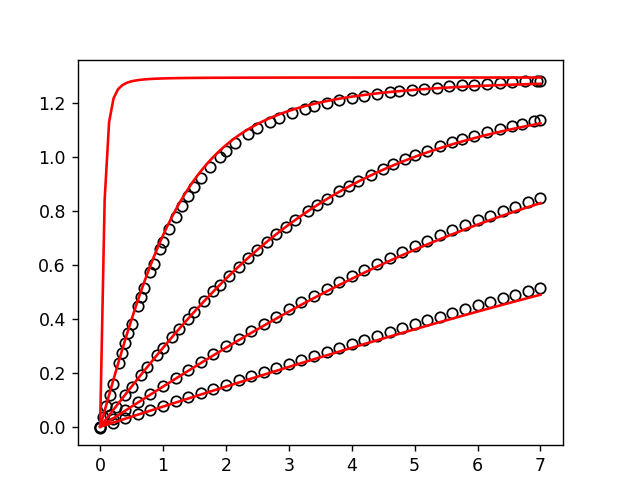

In [84]:
# plot dat and fit
Ts = [1.8, 5, 10, 20]
fig = plt.figure(figsize=(5,4))
plt.plot(mh[:,1],mh[:,2],'o',mec='black',mfc='none',markevery=0.02)
#plt.plot(mh_squid[:,1],mh_squid[:,2],'s')    

hdat=np.linspace(0.001,7, 100)
for t in np.hstack(([.1],Ts)).ravel():
    ydat = visingpow(hdat, t, popt)
    plt.plot(hdat,ydat,'r-')

# Plot the fit with fitted mass
#plt.plot(mh[:,1], visingpow(mh[:,1],mh[:,0], popt1[0])*popt1[1],'o',ms=1,c='black')

# Plot the fit with fitted chi_vv
#plt.plot(mh[:,1], visingpow(mh[:,1],mh[:,0], popt2[0])+popt2[1]*mh[:,1],'o',ms=1,c='grey')    

plt.show() 

[ 0.11763906  2.78183178  0.00903607]


<IPython.core.display.Javascript object>


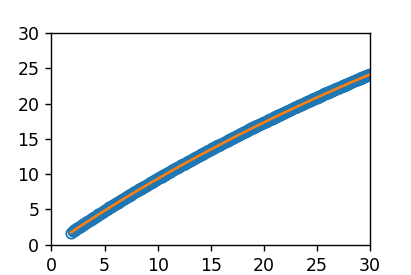

In [183]:
mt = np.genfromtxt(os.path.join(fpath,fnames[0]), usecols=(0,1,2), skip_header=0)

mt = Data(mt[:,[0,2]],column_headers=['Temperature (K)','DC Moment Free Ctr (emu)'], setas="xy")

mt.multiply('DC Moment Free Ctr (emu)', 1./1000/0.02432*637.8998/2, header='DC Moment Free Ctr (emu)', replace=True)

def chicw(t,tcw,mu,chivv):
    return 0.125 * mu**2 / (t-tcw) + chivv

fit=mt.curve_fit(chicw, xcol='Temperature (K)', ycol='DC Moment Free Ctr (emu)', bounds=lambda x,y: 5<x<15,
                 result=True, replace=False, header="Fit",output="report")

print(fit.report.popt)

plt.figure()
plt.plot(mt[:,0],1/mt[:,1],'o',mfc='none')
plt.plot(mt[:,0],1/mt[:,2])
plt.xlim([0,30])
plt.ylim([0,30])
plt.show()

### Nd3Sb3Zn2O14 (not Ising, so not appliable)

In [132]:
fpath = r'D:\3_Physical Properties\Nd3Sb3Zn2O14'
fnames = ['Nd3Sb3Mg2O14_powder_1stBatch_mt_0p1T.txt','Nd3Sb3Mg2O14_powder_1stBatch_mt_1T.txt',
          'Nd3Sb3Mg2O14_powder_1stBatch_mh_1p8_5_10_20K.txt']
mh = np.genfromtxt(os.path.join(fpath,fnames[2]), usecols=(0,1,2), skip_header=0)

# convert units
mh[:,1], mh[:,2] = mh[:,1]/10000, mh[:,2]/0.04842*1152.76/5585/3

# SQUID data
v=SFF.QDFile()
v.load(filename=r'D:\3_Physical Properties\Nd3Sb3Zn2O14\Nd3Sb3Zn2O14_powder_1stBatch_mt_mh_squid.dat')

ind = np.where(v[:,'Temperature (K)']==20.0007820129395)[0][0]
print ind
mh_squid = np.array([v[:ind,'Temperature (K)'],v[:ind,'Magnetic Field (Oe)']/10000,v[:ind,'DC Moment Free Ctr (emu)']/0.04842*1152.76/5585/3]).T
#print mh_squid
from Stoner import Data

177


TDI Format 1.5index,Time Stamp (sec) 1 (x),....,Moment (emu) 4 (y),M. Std. Err. (emu) 5,....,Map 16 68
Byapp{String}= MPMS3,3.74461e+09,,nan,nan,,nan
1.0 1.1,3.74461e+09,...,nan,nan,...,nan
"Datatype,Comment{I32",3.74461e+09,...,nan,nan,...,nan
}= 1,3.74461e+09,...,nan,nan,...,nan
"Datatype,Time{I32}=",3.74461e+09,...,nan,nan,...,nan
2,3.74461e+09,...,nan,nan,...,nan
Fieldgroup.Dc{List}=,3.74461e+09,...,nan,nan,...,nan
"[2, 3, 4, 14, 34,",3.74461e+09,...,nan,nan,...,nan
"35, 36, 37, 38, 39,",3.74461e+09,...,nan,nan,...,nan
"40, 41, 42, 43, 44,",3.74461e+09,...,nan,nan,...,nan


In [107]:
# Fit g factor
popt, pcov = optimize.curve_fit(multi_visingpow, mh[:,0:2], mh[:,2], p0=5.2)
print popt

[ 4.66155106]


<IPython.core.display.Javascript object>


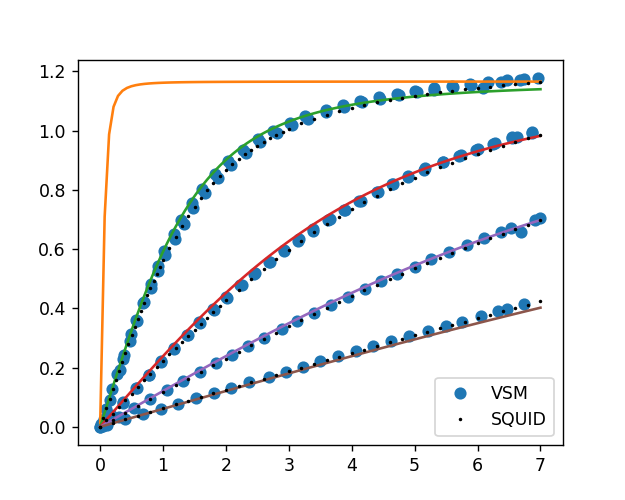

In [180]:
Ts = [1.8, 5, 10, 20]
fig = plt.figure(figsize=(5,4))
plt.plot(mh[:,1],mh[:,2],'o',markevery=0.03,label='VSM')
    
hdat=np.linspace(0.001,7, 100)
for t in np.hstack(([.1],Ts)).ravel():
    ydat = visingpow(hdat, t, popt)
    plt.plot(hdat,ydat)

plt.plot(mh_squid[:,1], mh_squid[:,2],'o',ms=1,c='black',label='SQUID')

plt.legend()
plt.show() 

[ 0.14339458  2.15158862  0.00542373]


<IPython.core.display.Javascript object>


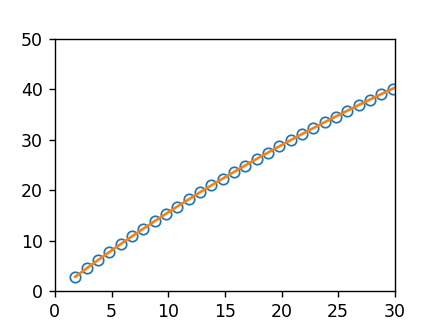

In [184]:
mt = v[ind+1:,['Temperature (K)','DC Moment Free Ctr (emu)']]
mt = Data(mt,column_headers=['Temperature (K)','DC Moment Free Ctr (emu)'], setas="xy")

mt.multiply('DC Moment Free Ctr (emu)', 1./1000/0.04842*1152.76/3, header='DC Moment Free Ctr (emu)', replace=True)

def chicw(t,tcw,mu,chivv):
    return 0.125 * mu**2 / (t-tcw) + chivv

fit=mt.curve_fit(chicw, xcol='Temperature (K)', ycol='DC Moment Free Ctr (emu)', bounds=lambda x,y: 5<x<15,
                 result=True,replace=False,header="Fit",output="report")

print(fit.report.popt)

#mt.plot(fmt='o')

plt.figure()
plt.plot(mt[:,0],1/mt[:,1],'o',mfc='none')
plt.plot(mt[:,0],1/mt[:,2])
plt.xlim([0,30])
plt.ylim([0,50])
plt.show()

### MH fitting of Sm2Zr2O7

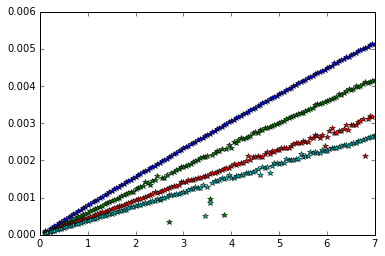

In [72]:
# Load and plot MH data
fpath = r'D:\3_Physical Properties\Sm2Zr2O7\SmZrO_pow_MH_2k_0-7T.txt'
fpath = r'D:\3_Physical Properties\Sm2Zr2O7\Sm2Zr2O7_29_03_2017_powder_MH_2-3-5-7K.txt' # why ten times smaller than old dat
mhdat = np.genfromtxt(fpath, usecols=(0,1), skip_header=0)
mhdat = np.hstack(np.vsplit(mhdat,4))# just for the 'MH 2-3-5-7K'
#print mhdat
Ts = [1.8] # temperatures or set 2K
Ts = [2, 3, 5, 7] # temperatures or set 2K
for i in xrange(0, mhdat.shape[1],2):
    mhdat[:,i] = mhdat[:,i] / 10000. # change the unit to Tesla

#plot data
for i in xrange(0, mhdat.shape[1],2):
    plt.plot(mhdat[:,i],mhdat[:,i+1],'*')

In [73]:
def err(t, g, x,y):
    x, y = x[~np.isnan(x)], y[~np.isnan(y)]   
    #err = visingpow(x, t, g) - y # use vectorized scipy function
    err = np.array([isingpow(x[i], t, g) - y[i] for i in np.arange(0, x.shape[0])]).ravel()
    return err
# have to put "ravel()" or 'flatten()' otherwise error on 'hstack' when using leastsq (no problem for non-fit use)

def err_global(g):
    err0=[]
    for i in range(len(Ts)):
        errc=err(Ts[i], g, mhdat[:,i*2],mhdat[:,i*2+1])
        err1=np.concatenate((err0,errc))
        err0=err1
    return err0 #(err0**2).sum()

# fit
p_best,success=optimize.leastsq(err_global, 0.3)
print p_best, success
#print err_global(p_best) 

[ 0.56365864] 1


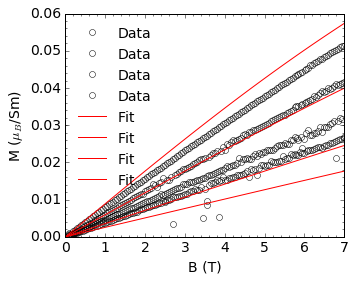

In [75]:
# plot dat and fit
fig = plt.figure(figsize=(5,4))
for i in xrange(0, mhdat.shape[1],2):
    plt.plot(mhdat[:,i],mhdat[:,i+1],linestyle='none', marker='o',mfc='none', mec='black', label='Data')
    
xdat=np.linspace(0.01,7, 100)
for t in Ts:
    ydat = np.array([isingpow(xdat[i], t, p_best[0]) for i in np.arange(0, xdat.shape[0])])
    plt.plot(xdat,ydat,c='r',label='Fit')
# for t in np.hstack(([0.1, 0.5, 1],Ts)).ravel():
#     ydat = np.array([isingpow(xdat[i], t, p_best[0]) for i in np.arange(0, xdat.shape[0])])
#     plt.plot(xdat,ydat)

# plt.text(5,0.02,'Sm$_2$Zr$_2$O$_7$\n1.8 K',size=14, ha='left', va='center', 
#             backgroundcolor='white',bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))

plt.xlabel('B (T)',size=14)
plt.ylabel('M ($\mu_B$/Sm)',size=14)

plt.minorticks_on()
plt.xticks( color='k', size=14)
plt.yticks( color='k', size=14)
plt.legend(loc='best',numpoints=1,frameon=False,framealpha=1,fontsize=14)
#fig.savefig(r'D:\3_Physical Properties\Sm2Zr2O7\SmZrO_pow_MH_2k_0-7T_fit.pdf', bbox_inches="tight",verbose=True)  
plt.show()


In [80]:
np.savetxt(r'D:\3_Physical Properties\Sm2Zr2O7\SmZrO_pow_MH_2k_0-7T_fit.txt',np.vstack([xdat*10000,ydat]).T,fmt='%.5f')


### Tb2Hf2O7 Ising fit

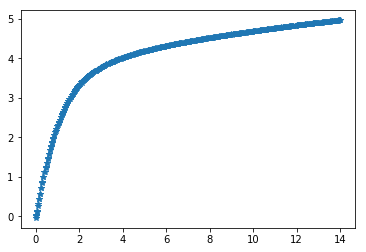

In [21]:
# Load and plot MH data
fpath = r'D:\3_Physical Properties\Tb2Ti2O7/MH_TbHfO_2K.dat'
mhdat = np.genfromtxt(fpath, usecols=(0,1), skip_header=0)
#print mhdat
Ts = [2] # temperatures or set 2K
mhdat[:,0] = mhdat[:,0] / 10000. # change the unit to Tesla
mhdat[:,1] = mhdat[:,1]/5585/2

#plot data
% matplotlib inline
plt.plot(mhdat[:,0],mhdat[:,1],'*')
plt.show()

In [25]:
def err(t, g, x,y):
    x, y = x[~np.isnan(x)], y[~np.isnan(y)]   
    #err = visingpow(x, t, g) - y # use vectorized scipy function
    err = np.array([isingpow(x[i], t, g) - y[i] for i in np.arange(0, x.shape[0])]).ravel()
    return err
# have to put "ravel()" or 'flatten()' otherwise error on 'hstack' when using leastsq (no problem for non-fit use)

def err_global(g):
    err0=[]
    for i in range(len(Ts)):
        errc=err(Ts[i], g, mhdat[:,i*2],mhdat[:,i*2+1])
        err1=np.concatenate((err0,errc))
        err0=err1
    return err0 #(err0**2).sum()

# fit
p_best,success=optimize.leastsq(err_global, 50)
print p_best, success
#print err_global(p_best) 

[ 0.3620708] 1


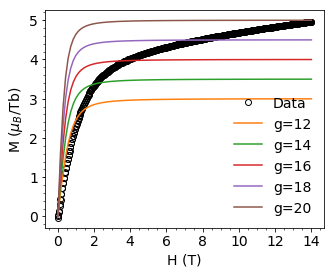

In [39]:
fig = plt.figure(figsize=(5,4))
for i in xrange(0, mhdat.shape[1],2):
    plt.plot(mhdat[:,i],mhdat[:,i+1],linestyle='none', marker='o',mfc='none', mec='black', label='Data')
    
xdat=np.linspace(0.01,14, 100)
for t in Ts:
    ydat = np.array([isingpow(xdat[i], t, 12) for i in np.arange(0, xdat.shape[0])])
    plt.plot(xdat,ydat,label='g=12')
    ydat = np.array([isingpow(xdat[i], t, 14) for i in np.arange(0, xdat.shape[0])])
    plt.plot(xdat,ydat,label='g=14')
    ydat = np.array([isingpow(xdat[i], t, 16) for i in np.arange(0, xdat.shape[0])])
    plt.plot(xdat,ydat,label='g=16')
    ydat = np.array([isingpow(xdat[i], t, 18) for i in np.arange(0, xdat.shape[0])])
    plt.plot(xdat,ydat,label='g=18')
    ydat = np.array([isingpow(xdat[i], t, 20) for i in np.arange(0, xdat.shape[0])])
    plt.plot(xdat,ydat,label='g=20')

plt.xlabel('H (T)',size=14)
plt.ylabel('M ($\mu_B$/Tb)',size=14)

plt.minorticks_on()
plt.xticks( color='k', size=14)
plt.yticks( color='k', size=14)
plt.legend(loc='best',numpoints=1,frameon=False,framealpha=1,fontsize=14)
#fig.savefig(r'D:\3_Physical Properties\Sm2Zr2O7\SmZrO_pow_MH_2k_0-7T_fit.pdf', bbox_inches="tight",verbose=True)  
plt.show()

# Heisenburg spin

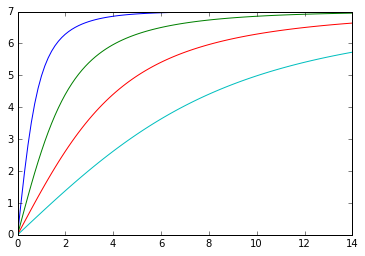

In [14]:
#　ＭＨ（Ｔ）　ｆｏｒ　　Ｈｅｉｓｅｎｂｕｒｇ　ｓｐｉｎ，　ｅｇ，Ｇｄ２Ｚｒ２Ｏ７

# use Ｓｙｍｐｙ which is not necessary. in the next cell we use numpy
import numpy as np
import sympy as sp

J = 3.5 # for Gd3+

mb = 0.6717 # in K/T, so field h is in T
kb = 1.0 # because mb is in K/T
j,t,g,h = sp.symbols('j,t,g,h')
def heisenM(h, t, g):
    # allp = sp.Sum(sp.exp(mb*g*j*h/(kb*t)),(j,-J, J)) # Sum: not work for non-integal J
    # m = sp.Sum(g*j*sp.exp(mb*g*j*h/(kb*t)),(j,-J, J))/allp
    
    allp = sum(sp.exp(mb*g*j*h/(kb*t)) for j in np.arange(-J, J+1)) # sum: list comprihensive
    m = sum(g*j*sp.exp(mb*g*j*h/(kb*t)) for j in np.arange(-J, J+1))/allp
    return m

#print heisenM(14., 5, 2.).doit()
heisenM = sp.lambdify((h, t,g), heisenM(h, t,g), modules=['numpy', 'sympy']) # vectorize the function

xdat=np.linspace(0.01,14, 100)
temps = np.array([2,5,10,20])

for temps in temps:
    ydat = heisenM(xdat,temps, 2.)
    plt.plot(xdat,ydat)

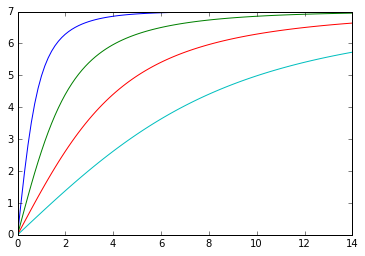

In [236]:
# use　ｎｕｍｐｙ

J = 3.5 # for Gd3+

mb = 0.6717 # in K/T, so field h is in T
kb = 1.0 # because mb is in K/T

def heisenM(h, t, g):
    allp = sum(np.exp(mb*g*j*h/(kb*t)) for j in np.arange(-J, J+1))
    m = sum(g*j*np.exp(mb*g*j*h/(kb*t)) for j in np.arange(-J, J+1))/allp
    return m

xdat=np.linspace(0.01,14, 100)
temps = np.array([2,5,10,20])
# heisenM(xdat,temps, 2.) could not brodacast

for temps in temps:
    ydat = heisenM(xdat,temps, 2.)
    plt.plot(xdat,ydat)

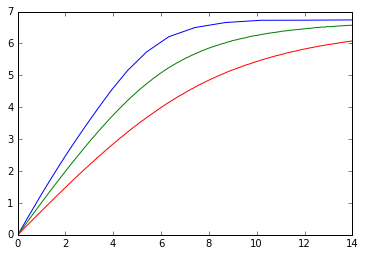

In [237]:
# load mh data
fpath = r'D:\3_Physical Properties\Gd2Zr2O7\1_Gd2Zr2O7_pow_MH.txt'
mhdat = np.genfromtxt(fpath, usecols=(0,1,2,3,4,5), skip_header=1) # MH at 1.8, 5, 10K

Ts = [1.8, 5., 10.] # temperatures

for i in xrange(0, mhdat.shape[1],2):
    mhdat[:,i] = mhdat[:,i] / 10000. # change the unit to Tesla

#print mhdat[:,0]
for i in xrange(0, mhdat.shape[1],2):
    plt.plot(mhdat[:,i],mhdat[:,i+1])
    

[ 1.66303415] 1


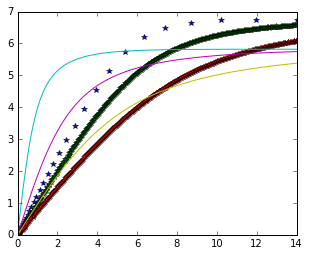

In [238]:
# multicureve fitting: def a global error
from scipy import optimize
import scipy as sc

def err(t,g, x,y):
    x, y = x[~np.isnan(x)], y[~np.isnan(y)]
    return heisenM(x, t, g) - y

def err_global(g):
    err0=[]
    for i in range(len(Ts)):
        errc=err(Ts[i], g, mhdat[:,i*2],mhdat[:,i*2+1])
        err1=np.concatenate((err0,errc))
        err0=err1
    return err0


# fit
p_best,success=optimize.leastsq(err_global, 2.)
print p_best, success
#print err_global(p_best)

# plot dat and fit
fig = plt.figure(figsize=(5,4))
for i in xrange(0, mhdat.shape[1],2):
    plt.plot(mhdat[:,i],mhdat[:,i+1],'*')
    
xdat=np.linspace(0.01,14, 100)
for t in Ts:
    ydat = heisenM(xdat, t, p_best[0])
    plt.plot(xdat,ydat)

plt.show()    

[ 1.28404615]
[ 1.28404654]
[ 1.65966659]
[ 1.65966675]
[ 1.70284275]
[ 1.70284287]


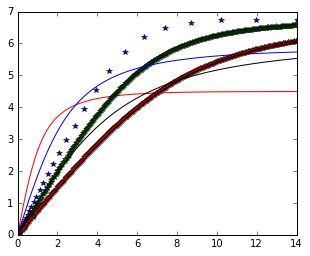

In [241]:
# single cruve fitting

def err(p, x, y):
    t, g = p[0], p[1]
    #print t, g
    #x, y = x[~np.isnan(x)], y[~np.isnan(y)]
    return heisenM(x, t, g) - y


fig = plt.figure(figsize=(5,4))
colors = ['red','blue','black']

xdat=np.linspace(0.01,14, 100)
for i in range(len(Ts)):
    x, y = mhdat[~np.isnan(mhdat[:,i*2]), i*2], mhdat[~np.isnan(mhdat[:,i*2+1]), i*2+1]
    
    # use curve_fit()
    #popt, pcov = optimize.curve_fit(heisenM, x, y) # fit both t and g
    popt, pcov = optimize.curve_fit( lambda h, g: heisenM(h, Ts[i],g), x, y) # fix t as the real one
    print popt
    
    # use leastsq()
    # p,cov, infodict, mesg, ier = optimize.leastsq(err, p_guess, args=(x,y),full_output=True)# fit both t and g
    p,cov, infodict, mesg, ier = optimize.leastsq( lambda g: err([Ts[i],g], x, y), 2., full_output=True)# only fit g
    print p #, infodict, mesg, ier
    
    
    plt.plot(x, y, '*')
    
    ydat = heisenM(xdat, Ts[i], p[0])
    plt.plot(xdat,ydat,c=colors[i])
    
plt.show() 

# export simulated data with g=2
expdat = np.zeros((100,4))
expdat[:,0] = xdat[:]
for i in range(len(Ts)):
    expdat[:,i+1] = heisenM(xdat, Ts[i], 2.)
#print expdat

# np.savetxt(r'D:\3_Physical Properties\Gd2Zr2O7\1_Gd2Zr2O7_pow_MH_cal_g2.txt', expdat, fmt='%1.4e')

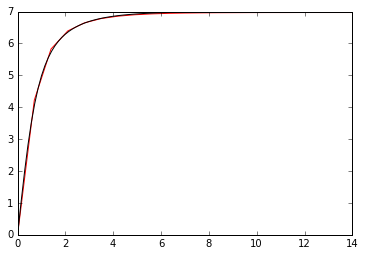

In [234]:
#　ＭＨ(z)　ｃａｌｃｕｌａｔｅｄ　ｂｙ　Ｓｐｅｃｔｒａ　ｗｉｔｈ　ｔｈｅ　Ｓｃａｌｅｄ　Ｎｄ　ＣＥＦ　ｐａｒｓ
# ｗｈｉｃｈ　ｉｓ　ｔｈｅ　ｓａｍｅ　ｗｉｔｈ　ｏｕｒｓ
import string

f = r'D:\9_Program files\crystal_field\Gd_scaledNd_MHz_2K.dat'

rule = string.maketrans('D', 'E') # make a translation table (rules) for translating a string (D to E in the numbers)

temp = np.genfromtxt(f, usecols=(0,1,2,3), \
                     converters = {1: lambda val: float(val.translate(rule)),
                                   2: lambda val: float(val.translate(rule)),
                                   3: lambda val: float(val.translate(rule))}) 
# 'val' given by 'genfromtxt' is a string, we can so use 'transleate' method

plt.plot(temp[:,0],temp[:,3],c='red')

xdat=np.linspace(0.01,14, 100)
ydat = heisenM(xdat, 2., 2.)
plt.plot(xdat,ydat,c='black')




# Stoner package

# Test Stoner package
"""Demonstrate Channel math operations."""
from Stoner import Data
from numpy import linspace,ones_like,sin,cos,pi
from numpy.random import normal
from Stoner.plot.utils import errorfill

x=linspace(0,10*pi,101)
e=0.01*ones_like(x)
y=0.1*sin(x)+normal(size=len(x),scale=0.01)+0.1
e2=0.01*cos(x)
y2=0.1*ones_like(x)
d=Data(x,y,e,y2,e2,column_headers=["$X$","$Y_+$",r"$\delta Y_+$","$Y_-$",r"$\delta Y_-$"],setas="xyeye")

a=tuple(d.column_headers[1:3])
b=tuple(d.column_headers[3:5])

d.add(a,b,replace=False)
d.subtract(a,b,replace=False)
d.multiply(a,b,replace=False)
d.divide(a,b,replace=False)
d.diffsum(a,b,replace=False)
d.setas="xyeyeyeyeyeyeye"
d.plot(multiple="panels",plotter=errorfill,color="red",alpha_fill=0.2)